# Palestinian accents classifier project

### include the necessary libraries if they are not included

In [315]:
import os
import glob
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import warnings
warnings.filterwarnings('ignore')

### function to load audio files

In [316]:
def load_audio_files(base_path):
    features = []
    labels = []
    accents = ['Hebron', 'Jerusalem', 'Nablus','Ramallah_Reef']

    for accent in accents:
        folder_path = os.path.join(base_path, accent)
        for file_path in glob.glob(os.path.join(folder_path, '*.wav')):
            y, sr = librosa.load(file_path, sr=None)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)#we take 20 mfccs
            mfccs_mean = np.mean(mfccs, axis=1)
#           mfccs_delta = librosa.feature.delta(mfccs)
#           mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
            features += [mfccs_mean]
            labels.append(accent)

    return np.array(features), np.array(labels)

In [317]:
best_svm = None
best_Kmeans = None

In [195]:
data_saved = False # only trun this line if you've changed on the code that exctracts the features (.npy files have changed).

In [318]:
data_saved = True # run this line if you want to read the features and labels directly from the .npy files.

In [319]:
train_base_path = 'training' # can use 'training_segmented' to run the training data that is split into smaller speech files. 
test_base_path = 'testing' # same as above, but for the testing data.
features_train, labels_train, features_test, labels_test = None, None, None, None

### A function that loads the .wav files into .npy files and assigns the features and labels for testing and training data.

In [320]:
def read_save_data():
    global data_saved
    if not data_saved:
        features_train, labels_train = load_audio_files(train_base_path)#training features and labels
        features_test, labels_test = load_audio_files(test_base_path)# testing features and labels
        np.save('features_train.npy', features_train)
        np.save('labels_train.npy', labels_train)
        np.save('features_test.npy', features_test)
        np.save('labels_test.npy', labels_test)
        data_saved = True

### This section assigns features and labels for testsing and training data (using the above function or by reading the .npy if they already exist)

In [321]:
t0 = time()
if not data_saved:
    read_save_data()
    
else: # data is saved to the .npy file and not changed (so we read it directly).
    features_train = np.load('features_train.npy')
    labels_train = np.load('labels_train.npy')
    features_test = np.load('features_test.npy')
    labels_test = np.load('labels_test.npy')
    print('data loaded successfully')
t1 = time()

deltaT = (t1 - t0)
print(f'time taken = {deltaT:.2f} seconds')

data loaded successfully
time taken = 0.01 seconds


### this function is used to scale the features for both train and test data using StandardScaler

In [322]:
def scale_values():
    global features_train
    global features_test
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)

## This section is for the SVM model

### this method is used to train the SVM models and choose the best model using grid search

In [323]:
def choose_best_SVM():
    global features_train
    global labels_train
    global best_svm
    # Use Grid Search to find the best parameters for SVM
    parameter_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'class_weight': ['balanced']}
    
    grid_search = GridSearchCV(SVC(), parameter_grid, cv=5)
    grid_search.fit(features_train, labels_train)
    # Get the best model from Grid Search
    best_svm = grid_search.best_estimator_

### This method performs K-Means clustering on the training data

In [324]:
def evaluate_SVM():
    global best_svm
    """This method evaluates the best SVM , print the accuracy, confusion matrix and classification report"""
    y_pred = best_svm.predict(features_test)
    accuracy = accuracy_score(labels_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    # Print confusion matrix and classification report
    cm_svm = confusion_matrix(labels_test, y_pred, labels=best_svm.classes_)
    sns.heatmap(cm_svm, annot=True, fmt='d', xticklabels=best_svm.classes_, yticklabels=best_svm.classes_,cmap='binary', linewidths=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels_test, y_pred, target_names=best_svm.classes_))

In [325]:
print('scaling values..')
scale_values()
print('scaling values done.')

scaling values..
scaling values done.


In [326]:
print('choosing best SVM model..')
choose_best_SVM()
print('choosing best SVM model done.')

choosing best SVM model..
choosing best SVM model done.


evaluating SVM model..
Accuracy: 80.00%


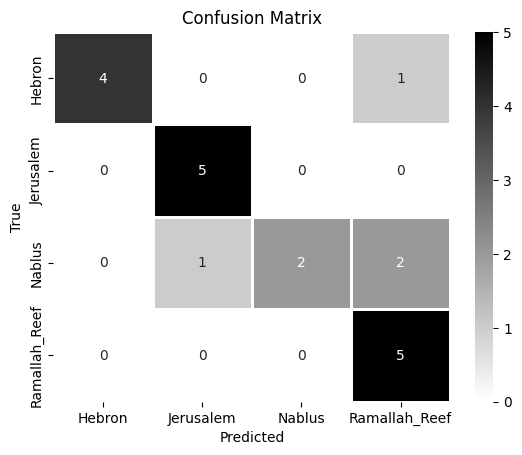

               precision    recall  f1-score   support

       Hebron       1.00      0.80      0.89         5
    Jerusalem       0.83      1.00      0.91         5
       Nablus       1.00      0.40      0.57         5
Ramallah_Reef       0.62      1.00      0.77         5

     accuracy                           0.80        20
    macro avg       0.86      0.80      0.78        20
 weighted avg       0.86      0.80      0.78        20

evaluating SVM model done.


In [327]:
print('evaluating SVM model..')
evaluate_SVM()
print('evaluating SVM model done.')

## this section is for the Neural Network model.

### import necessary functions

In [328]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

### Scale the features

In [329]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

### Convert labels to categorical (one-hot encoding)

In [330]:
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

### Define the parameter grid

In [331]:
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'learning_rate_init': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'activation': ['relu', 'tanh', 'logistic', 'identity']
}

### Create the MLP classifier

In [332]:
mlp = MLPClassifier(max_iter=100)

### Perform Grid Search

In [333]:
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5)
grid_result = grid_search.fit(features_train_scaled, labels_train_encoded)

### Print the best parameters and the corresponding accuracy

In [308]:
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

Best Parameters:  {'activation': 'identity', 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.2}
Best Accuracy:  0.75


### Train the MLP classifier with the best parameters


In [313]:
best_mlp = MLPClassifier(**grid_result.best_params_, max_iter=100)
best_mlp.fit(features_train_scaled, labels_train_encoded)

MLPClassifier(activation='identity', hidden_layer_sizes=(128, 64),
              learning_rate_init=0.2, max_iter=100)

### Evaluate the model


In [314]:
labels_pred = best_mlp.predict(features_test_scaled)
accuracy = accuracy_score(labels_test_encoded, labels_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.75


### Print confusion matrix and classification report

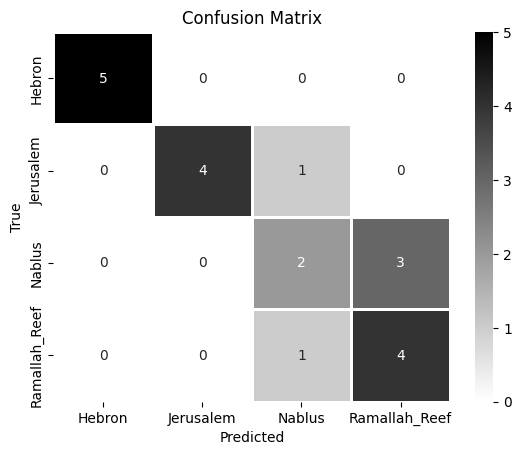

Classification Report:
               precision    recall  f1-score   support

       Hebron       1.00      1.00      1.00         5
    Jerusalem       1.00      0.80      0.89         5
       Nablus       0.50      0.40      0.44         5
Ramallah_Reef       0.57      0.80      0.67         5

     accuracy                           0.75        20
    macro avg       0.77      0.75      0.75        20
 weighted avg       0.77      0.75      0.75        20



In [335]:
cm_nn = confusion_matrix(labels_test_encoded, labels_pred)
sns.heatmap(cm_nn, annot=True, fmt='d', xticklabels=best_svm.classes_, yticklabels=best_svm.classes_,cmap='binary', linewidths=1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(labels_test_encoded, labels_pred, target_names=label_encoder.classes_))